# Classification of Moscow Metro stations

## Introduction

Moscow Metro has 265 stations and is one of the largest public transit systems in the world. It is used by more than 6 million people daily.  
For this project, we want to look at the neighborhoods surrounding metro stations and classify them. Some neighborhoods are mostly residential, some have more business or commercial spaces surrounding them. The venues closest to a station determine why and how people use it. E.g. if there are no professional places in a neighborhood its residents are likely to travel to other areas for work. This creates daily migrations of people.  
By analyzing this data we can classify stations by primary usage. This data is useful for city planners to determine where from and where to people are most likely to travel for work and leisure. This can help plan further extension of the network and find places for new development.

## Data

In [249]:
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import re

### List of stations and their geographical coordinates
We can get the list of stations and their coordinates from Wikipedia

In [298]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'
wiki_page = requests.get(wiki_url).text
wiki_doc = BeautifulSoup(wiki_page, 'lxml')

# get the table containing the postal codes
stations_table = wiki_doc.find('table', {'class': 'wikitable sortable'})

In [299]:
# Grab English name, Russian name and coordinates (convert to comma-separated) from list
indices = [0,1,6]

stations_df = pd.DataFrame(columns=['Line','English name','Russian name','Coordinates'])

for tr in stations_table.find_all('tr')[1:]:
    line = re.search('#(.+?)\s', tr.find('a')['title']).group(1)
    cells = tr.find_all('td')
    #ignore cells that don't have coordinates
    if cells[6].text.strip() != '':
        stations_df = stations_df.append({
            'Line': line,
            'English name': cells[0].text.strip(),
            'Russian name': cells[1].text.strip(),
            'Coordinates': cells[6].find('span', {'class': 'geo'}).text.strip().replace('; ',',')
        }, ignore_index=True)    
        
stations_df.head()
stations_df.to_csv('stations.csv')

In [333]:
# Read already downloaded csv
stations_df = pd.read_csv('stations.csv', index_col=0)
stations_df.head()

,Line,English name,Russian name,Coordinates
0,1,Bulvar Rokossovskogo,Бульвар Рокоссовского,"55.8148,37.7342"
1,1,Cherkizovskaya,Черкизовская,"55.8038,37.7448"
2,1,Preobrazhenskaya Ploshchad,Преображенская площадь,"55.7963,37.7151"
3,1,Sokolniki,Сокольники,"55.7888,37.6802"
4,1,Krasnoselskaya,Красносельская,"55.7801,37.6673"


Let's visualize the stations data by drawing the stations and lines

In [328]:
# Line color codes
line_colors = {
    '1':'#EF161E',
    '2':'#2DBE2C',
    '3':'#0078BE',
    '4':'#00BFFF',
    '5':'#8D5B2D',
    '6':'#ED9121',
    '7':'#800080',
    '8':'#FFD702',
    '8A':'#FFD702',
    '9':'#999999',
    '10':'#99CC00',
    '11':'#82C0C0',
    '11A':'#82C0C0',
    '12':'#A1B3D4',
    '13':'#9999FF',
    '14':'#FFFFFF',
    '15':'#DE64A1'
}

#create map of Moscow with all stations
map_moscow_metro = folium.Map(location=[55.755825, 37.617298], zoom_start=10)
#add markers
for line, station, coordinates in zip(stations_df['Line'], stations_df['English name'], stations_df['Coordinates']):
    latlong = [float(x) for x in coordinates.split(',')]
    #Also add a 500-meter circle around the station to visualize our neighborhoods
    #folium.Circle(
    #    latlong,        
    #    radius=1000,
    #    color=line_colors[line]
    #).add_to(map_moscow_metro)
    #Add marker with popup
    folium.Circle(
        latlong,
        popup=station,
        radius=20,
        color=line_colors[line]
    ).add_to(map_moscow_metro)
    if line != prev_line:
        prev_coordinates = None    
    if prev_coordinates != None:
        folium.PolyLine([prev_coordinates, latlong], color=line_colors[line]).add_to(map_moscow_metro)    
    prev_line = line
    prev_coordinates = latlong    

def draw_lines(dataframe, map_object, opacity=1):
    prev_coordinates = None
    prev_line = '1'
    for line, coordinates in zip(dataframe['Line'], dataframe['Coordinates']):
        latlong = [float(x) for x in coordinates.split(',')]
        #don't draw line if line number changed
        if line != prev_line:
            prev_coordinates = None
        if prev_coordinates != None:
            folium.PolyLine([prev_coordinates, latlong], color=line_colors[line], opacity=opacity).add_to(map_object)
        prev_line = line
        prev_coordinates = latlong    
    
    #special case for two circle lines
    for line in ['5','14']:
        first_station = dataframe[dataframe['Line'] == line].iloc[0]['Coordinates']
        last_station = dataframe.iloc[dataframe[stations_df['Line'] == line].last_valid_index()]['Coordinates']    
        print()
        print()
        folium.PolyLine([[float(x) for x in first_station.split(',')],
                         [float(x) for x in last_station.split(',')]],
                        color=line_colors[line], opacity=opacity).add_to(map_object)

draw_lines(stations_df, map_moscow_metro)
map_moscow_metro

### Venues and categories
We will use Foursquare API to explore venue categories surrounding each station. Venues can be categorized as residential, professional, shopping or leisure.
Let's see what venue categories Foursquare identifies.

In [305]:
secrets = json.load(open('secrets.json'))
CLIENT_ID = secrets['CLIENT_ID']
CLIENT_SECRET = secrets['CLIENT_SECRET']
VERSION = secrets['VERSION']

In [306]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [307]:
len(results['response']['categories'])

10

There are 10 top-level categories and multiple subcategories

In [308]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


## Methodology 

We can use the foursquare explore API with categoryId to query the number of venues of each category in a specific radius. The response contains a totalResults value for the specified coordinates, radius and category.

In [309]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [310]:
#Create new dataframe to store venues data
stations_venues_df = stations_df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [311]:
#Request number of venues, store result as CSV
for i, row in stations_venues_df.iterrows():
    print(i)
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Coordinates.iloc[i], radius=1000, categoryId=c[1])
    stations_venues_df.to_csv('stations_venues.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


In [235]:
#Read already stored CSV
stations_venues_df = pd.read_csv('stations_venues_1000.csv', index_col=0)
stations_venues_df.head()

,English name,Russian name,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Bulvar Rokossovskogo,Бульвар Рокоссовского,"55.8148,37.7342",5,8,0,11,6,9,46,6,55,9
1,Cherkizovskaya,Черкизовская,"55.8038,37.7448",5,25,0,12,4,19,38,7,36,10
2,Preobrazhenskaya Ploshchad,Преображенская площадь,"55.7963,37.7151",13,26,0,31,5,31,110,21,81,14
3,Sokolniki,Сокольники,"55.7888,37.6802",16,20,0,56,13,43,90,27,81,18
4,Krasnoselskaya,Красносельская,"55.7801,37.6673",31,25,0,107,28,25,134,23,91,70


### Exploratory analysis & basic cleanup
Plot the number of venues as boxplots

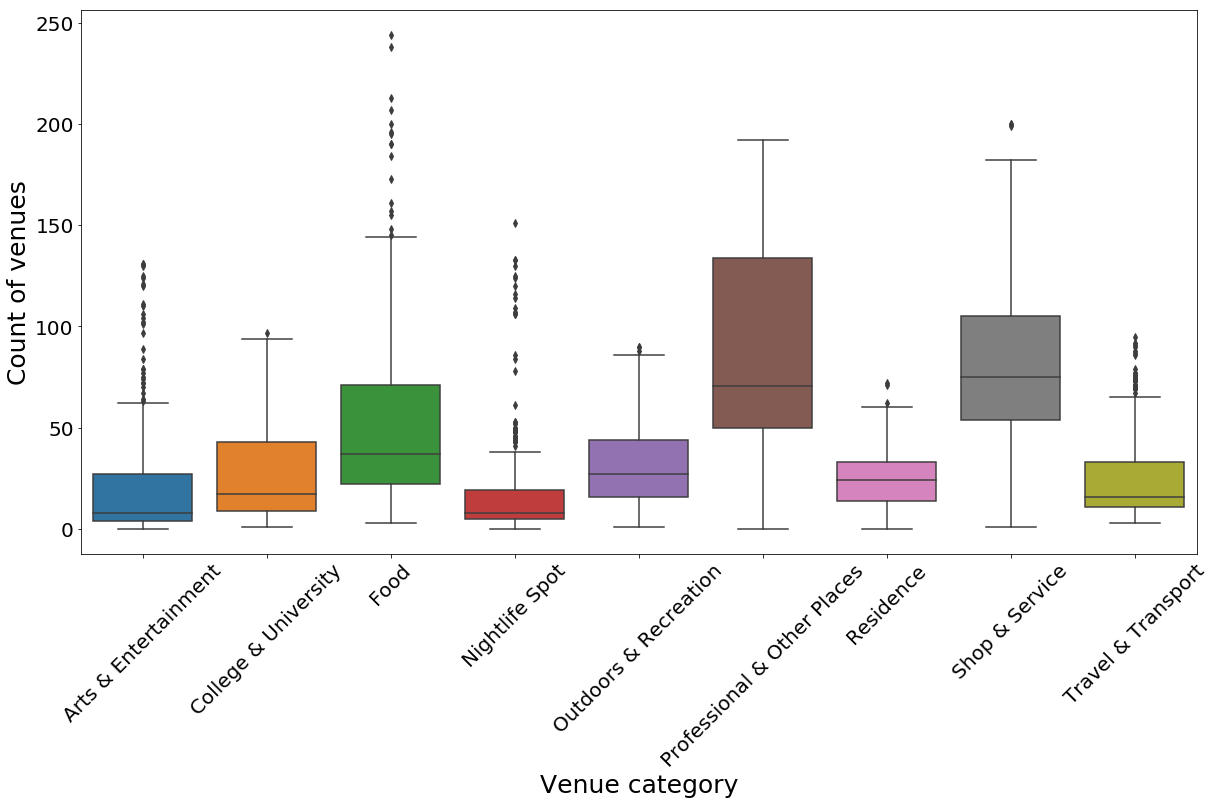

In [348]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = stations_venues_df)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45)

plt.show()

The most frequent venue categories are professional, shop&service and food. Event has very little data, let's discard it from both the dataframe and the list of categories.

In [313]:
stations_venues_df.drop('Event', 1, inplace=True)

In [314]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

### Data preparation

Let's normalize the data using MinMaxScaler (scale from 0 to 1). This scales the data and provides an easy to interpret score at the same time.

In [316]:
from sklearn.preprocessing import MinMaxScaler

X = stations_venues_df.values[:,4:]
cluster_dataset = MinMaxScaler().fit_transform(X)

C:\Users\thept\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [317]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.038168,0.072917,0.033195,0.039735,0.089888,0.239583,0.083333,0.271357,0.065217
1,0.038168,0.250000,0.037344,0.026490,0.202247,0.197917,0.097222,0.175879,0.076087
2,0.099237,0.260417,0.116183,0.033113,0.337079,0.572917,0.291667,0.402010,0.119565
3,0.122137,0.197917,0.219917,0.086093,0.471910,0.468750,0.375000,0.402010,0.163043
4,0.236641,0.250000,0.431535,0.185430,0.269663,0.697917,0.319444,0.452261,0.728261


Visualize the scaled data.

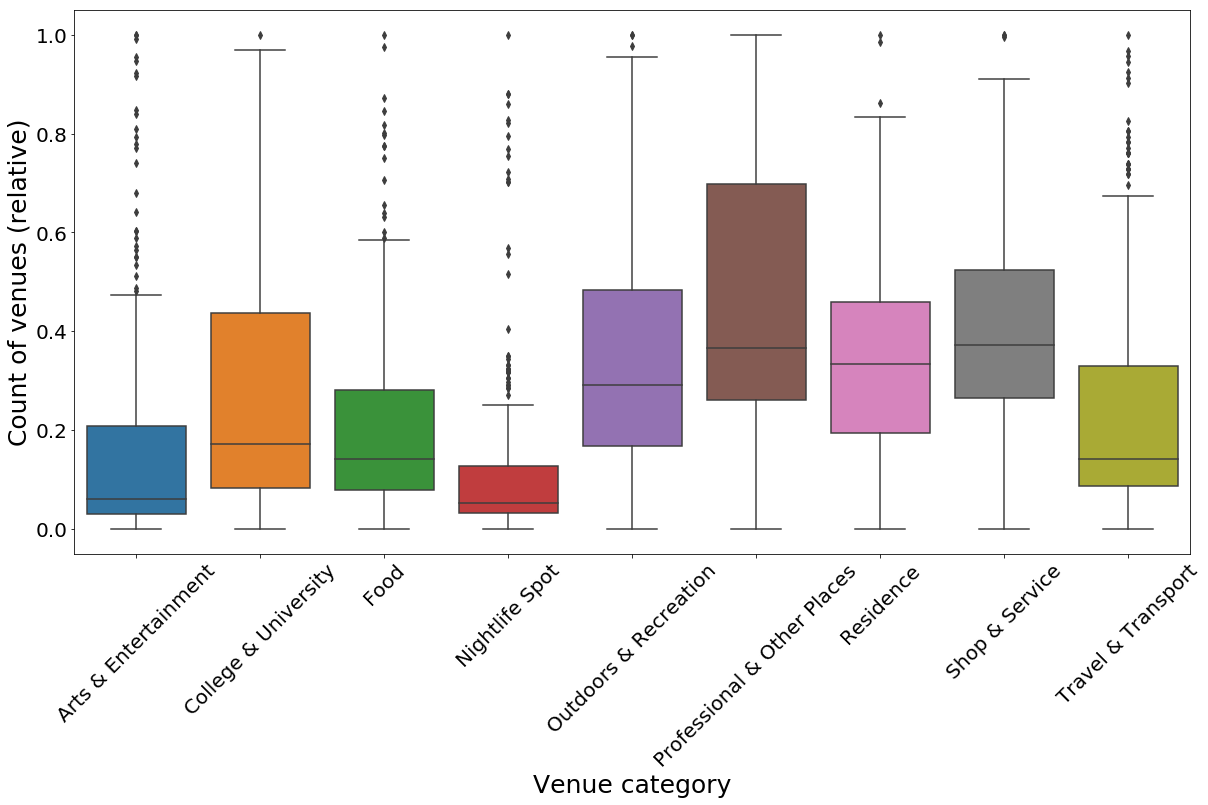

In [349]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45)

plt.show()

### Clustering
We'll be using k-means clustering.
These were preliminary results with different number of clusters:  
- 2 clusters only show the uptown/downtown divide
- 3 clusters add clustering within the downtown
- 4 clusters also identify neighborhoods with very low number of venues
- 5 and more clusters are difficult to interpret  

For the final analysis let's settle on 4 clusters.

In [324]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = stations_venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['English name'] = stations_df['English name']
stations_clusters_minmax_df['Coordinates'] = stations_df['Coordinates']

Visualize the clusters with boxplots

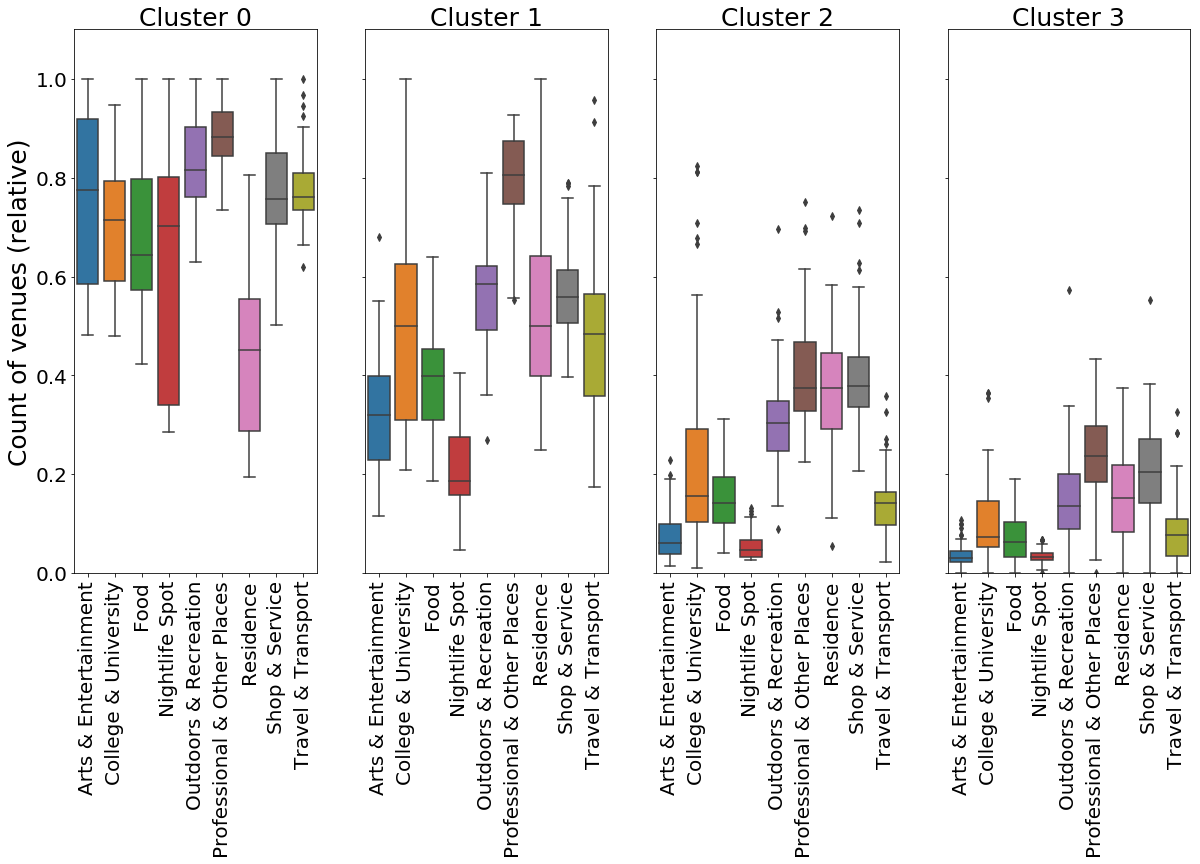

In [354]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

Map the data. For each station we'll display top 3 venue categories.

In [331]:
#create map of Moscow with all stations
map_moscow_metro = folium.Map(location=[55.755825, 37.617298], zoom_start=10)

draw_lines(stations_df, map_moscow_metro, 0.9)

#add markers
for i, station, coordinates, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['English name'],
                                         stations_clusters_minmax_df['Coordinates'],
                                         stations_clusters_minmax_df['Cluster']):
    latlong = [float(x) for x in coordinates.split(',')]    
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','orange','red']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker(
        latlong,
        fill=True,
        fill_opacity=0.5,
        popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster]
    ).add_to(map_moscow_metro)
    
map_moscow_metro

In [332]:
map_moscow_metro.save('map\index.html')

## Results

Here is how we can characterize the clusters by looking at venue scores
- Cluster 0 (Blue) has consistently high scores for all venue categories. This is the most diversely developed part of the city
- Cluster 1 (Green) has highest marks for Professional&Other Places. This is the business part of the city.
- Cluster 2 (Orange) has lower marks with best scores in Profiessional, Residence and Shop&Service.
- Cluster 3 (Red) has low marks across the board. These appear to be underdeveloped areas.  

Plotting the clusters on a map shows us that
- Cluster 0 is the oldest central part of the city
- Cluster 1 is also downtown. Most of these stations are inside or near the [Circle Line](https://en.wikipedia.org/wiki/Koltsevaya_line) and have excellent transit accessibility.
- Clusters 2 and 3 aren’t so clearly geographically distributed. Cluster 3 areas tend to be at the outskirts but some are more centrally located.

Some stations were classified as Cluster 4 despite being more centrally and accessibly located. This could be a legacy of the “Rust Belt” of closed and abandoned factories (https://www.vesti.ru/doc.html?id=3030139&cid=4441). Many stations of the recently opened [Moscow Central Circle railway](https://en.wikipedia.org/wiki/Moscow_Central_Circle) fall into this category. These are prime areas for business and residential development.

## Discussion

To be fair, Foursquare data isn’t all-encompassing. The highest number of venues are in the Food and Shop & Service categories. Data doesn’t take into account a venue’s size (e.g. a university building attracts a lot more people that a hot dog stand – each of them is still one Foursquare “venue”).

## Conclusion

Foursquare data is limited but can provide insights into a city’s development. This data could be combined with other sources (e.g. city data on number of residents) to provide more accurate results.